## Functional API - Book chapter 7.1

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2023-05-07 18:59:42.958355: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-07 18:59:43.010296: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-07 18:59:43.306547: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-07 18:59:43.308230: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-07 18:59:45.455057: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

#Residual connection

In [2]:
from keras.layers import Conv2D, Input

# input tensor for a 3-channel 256x256 image
x = Input(shape=(256, 256, 3))
# 3x3 conv with 3 output channels (same as input channels)
F_x = Conv2D(3, (3, 3), padding='same')(x)
# this returns x + y.
y = keras.layers.add([x, F_x]) #Shua: performs simple addition of the inputs.

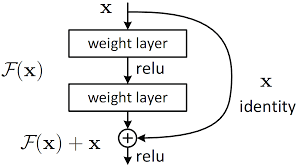

# Resnet toy example

In [3]:
inputs = keras.Input(shape=(28, 28, 1), name="img")
x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.Conv2D(64, 3, activation="relu")(x)
block_1_output = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = layers.add([x, block_1_output]) #Resnet block #1

x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = layers.add([x, block_2_output]) #Resnet block #2

x = layers.Conv2D(64, 3, activation="relu")(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10)(x)

model = keras.Model(inputs, outputs, name="toy_resnet")
model.summary()

Model: "toy_resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 26, 26, 32)   320         ['img[0][0]']                    
                                                                                                  
 conv2d_2 (Conv2D)              (None, 24, 24, 64)   18496       ['conv2d_1[0][0]']               
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 8, 8, 64)     0           ['conv2d_2[0][0]']               
                                                                                         

In [4]:
# Use the shared_vision_model on MNIST
from keras.datasets import mnist
from keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape((60000, 28, 28, 1))
x_test = x_test.reshape((10000, 28, 28, 1))

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

model.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['accuracy'])

model.fit(x_train, y_train,
            batch_size=128,
            epochs=10,
            validation_data=(x_test, y_test))

Epoch 1/10
 21/469 [>.............................] - ETA: 1:19 - loss: 0.4460 - accuracy: 0.1105

KeyboardInterrupt: 

In [14]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 7s 22ms/step - loss: 0.0113 - accuracy: 0.9917


[0.011331514455378056, 0.9916999936103821]

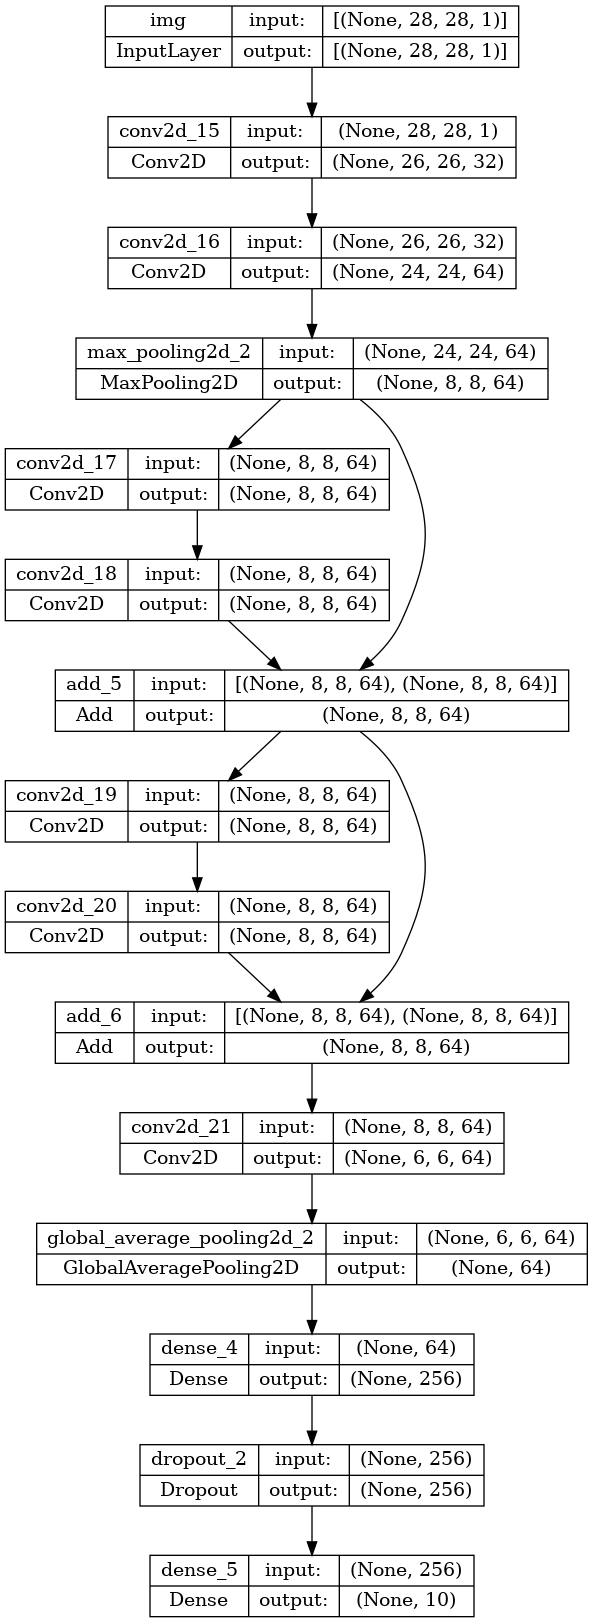

In [11]:
keras.utils.plot_model(model, "mini_resnet.png", show_shapes=True)

In [26]:
#Now write out the resnet model in pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.conv4 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 3)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 3)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 3)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5)
        x = self.fc2(x)
        return x
#graph the model using torchsummary
from torchsummary import summary
model = ResNet()
summary(model, (1, 28, 28))

RuntimeError: Calculated padded input size per channel: (1 x 1). Kernel size: (3 x 3). Kernel size can't be greater than actual input size

#Inception module


In [21]:
from keras.layers import Conv2D, MaxPooling2D, Input, Concatenate, Dense, Flatten

input_img = Input(shape=(28, 28, 1))

tower_1 = Conv2D(64, (1, 1), padding='same', activation='relu')(input_img)
tower_1 = Conv2D(64, (3, 3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(64, (1, 1), padding='same', activation='relu')(input_img)
tower_2 = Conv2D(64, (5, 5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_img)
tower_3 = Conv2D(64, (1, 1), padding='same', activation='relu')(tower_3)

mid_1 = keras.layers.concatenate([tower_3, tower_2, tower_3], axis = 3)

x = Flatten()(mid_1)
out = Dense(10, activation='softmax')(x)
inception = keras.Model(input_img, out, name="inception")
inception.summary()

Model: "inception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 max_pooling2d_7 (MaxPooling2D)  (None, 28, 28, 1)   0           ['input_6[0][0]']                
                                                                                                  
 conv2d_44 (Conv2D)             (None, 28, 28, 64)   128         ['input_6[0][0]']                
                                                                                                  
 conv2d_46 (Conv2D)             (None, 28, 28, 64)   128         ['max_pooling2d_7[0][0]']        
                                                                                          

In [22]:
# Use the shared_vision_model on MNIST

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape((60000, 28, 28, 1))
x_test = x_test.reshape((10000, 28, 28, 1))

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

inception.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['accuracy'])

inception.fit(x_train, y_train,
            batch_size=128,
            epochs=10,
            validation_data=(x_test, y_test))

Epoch 1/10
469/469 [==============================] - 295s 626ms/step - loss: 0.0529 - accuracy: 0.9287 - val_loss: 0.0183 - val_accuracy: 0.9769
Epoch 2/10
469/469 [==============================] - 292s 623ms/step - loss: 0.0175 - accuracy: 0.9796 - val_loss: 0.0170 - val_accuracy: 0.9808
Epoch 3/10
469/469 [==============================] - 287s 612ms/step - loss: 0.0132 - accuracy: 0.9848 - val_loss: 0.0119 - val_accuracy: 0.9856
Epoch 4/10
469/469 [==============================] - 285s 607ms/step - loss: 0.0108 - accuracy: 0.9883 - val_loss: 0.0121 - val_accuracy: 0.9861
Epoch 5/10
469/469 [==============================] - 296s 632ms/step - loss: 0.0091 - accuracy: 0.9905 - val_loss: 0.0107 - val_accuracy: 0.9881
Epoch 6/10
469/469 [==============================] - 294s 627ms/step - loss: 0.0078 - accuracy: 0.9920 - val_loss: 0.0119 - val_accuracy: 0.9864
Epoch 7/10
469/469 [==============================] - 276s 588ms/step - loss: 0.0067 - accuracy: 0.9937 - val_loss: 0.0119 -

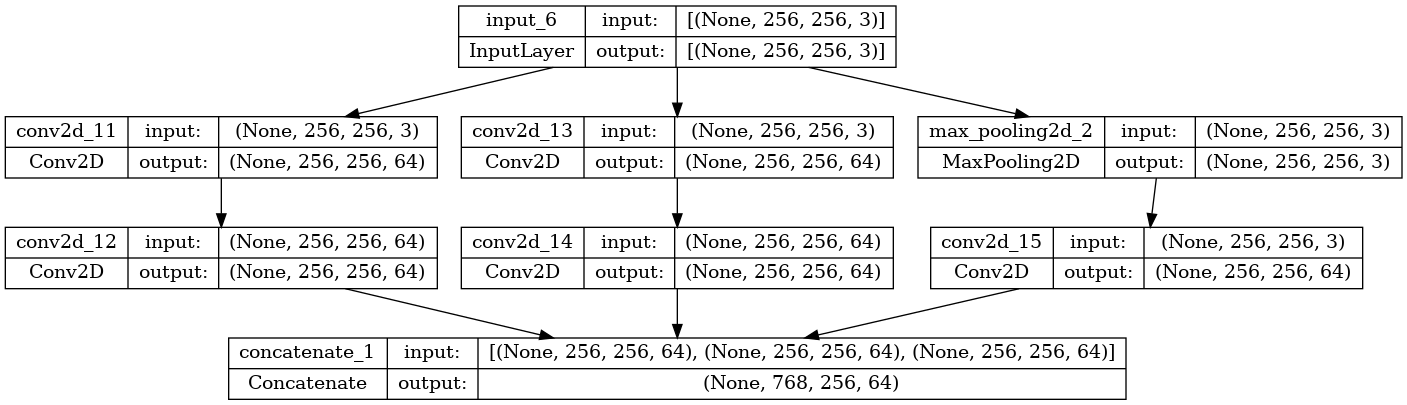

In [13]:
keras.utils.plot_model(inception, "mini_inception.png", show_shapes=True)

#Shared vision model
##This model reuses the same image-processing module on two inputs, to classify whether two MNIST digits are the same digit or different digits.


In [52]:

from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten
from keras.models import Model

# First, define the vision modules
digit_input = Input(shape=(28, 28, 1))
x = Conv2D(64, (3, 3))(digit_input)
x = Conv2D(64, (3, 3))(x)
x = MaxPooling2D((2, 2))(x)
out = Flatten()(x)

vision_model = Model(digit_input, out, name = 'vision_model')

# Then define the tell-digits-apart model
digit_a = Input(shape=(28, 28, 1))
digit_b = Input(shape=(28, 28, 1))

# The vision model will be shared, weights and all
out_a = vision_model(digit_a)
out_b = vision_model(digit_b)

concatenated = keras.layers.concatenate([out_a, out_b])
out = Dense(1, activation='sigmoid')(concatenated) #original code had "1", needed to change to 10.

shared_vision_model = Model([digit_a, digit_b], out, name = 'shared_vision')

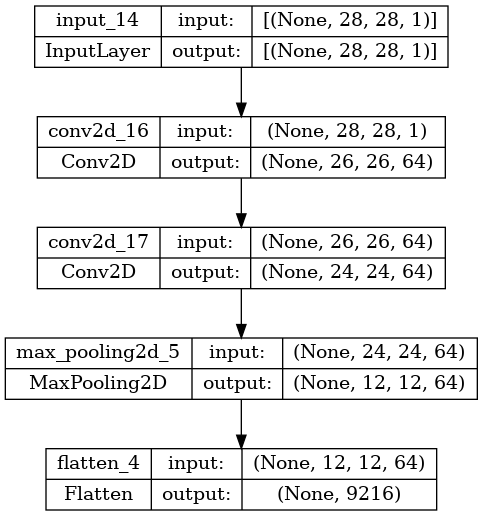

In [53]:
keras.utils.plot_model(vision_model, "vision.png", show_shapes=True)

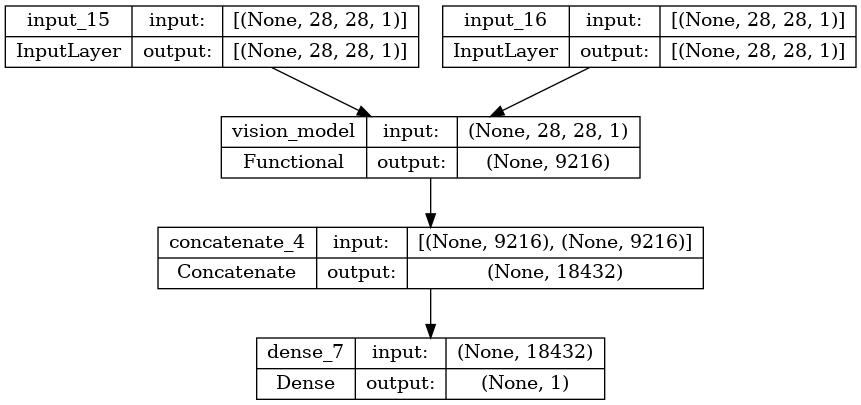

In [54]:
keras.utils.plot_model(shared_vision_model, "shared_vision.png", show_shapes=True)

In [59]:
# Compile the shared vision model
from keras.optimizers import Adam
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Preprocess the data
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.
train_images = np.expand_dims(train_images, -1)
test_images = np.expand_dims(test_images, -1)

def create_pairs(images, labels, num_pairs=20000):
    num_classes = len(np.unique(labels))
    digit_indices = [np.where(labels == i)[0] for i in range(num_classes)]
    pairs = []
    pair_labels = []
    
    for _ in range(num_pairs // 2):
        # Positive pairs (same digit)
        class_idx = np.random.randint(num_classes)
        idx1, idx2 = np.random.choice(digit_indices[class_idx], size=2, replace=False)
        pairs.append([images[idx1], images[idx2]])
        pair_labels.append(1)
        
        # Negative pairs (different digits)
        class1_idx, class2_idx = np.random.choice(num_classes, size=2, replace=False)
        idx1 = np.random.choice(digit_indices[class1_idx])
        idx2 = np.random.choice(digit_indices[class2_idx])
        pairs.append([images[idx1], images[idx2]])
        pair_labels.append(0)

    # Shuffle pairs and labels
    shuffled_indices = np.random.permutation(len(pairs))
    pairs = np.array(pairs)[shuffled_indices]
    pair_labels = np.array(pair_labels)[shuffled_indices]
    
    return pairs, pair_labels

# Create pairs for training and testing
train_pairs, train_pair_labels = create_pairs(train_images, train_labels)
test_pairs, test_pair_labels = create_pairs(test_images, test_labels)
# Train the shared vision model


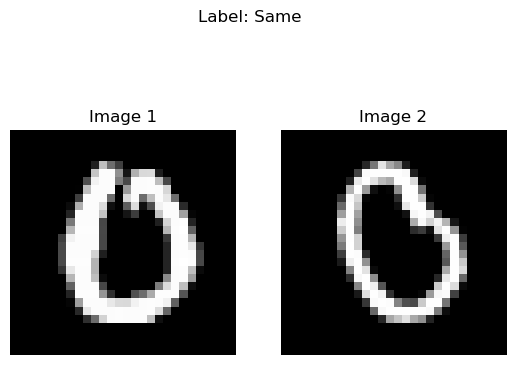

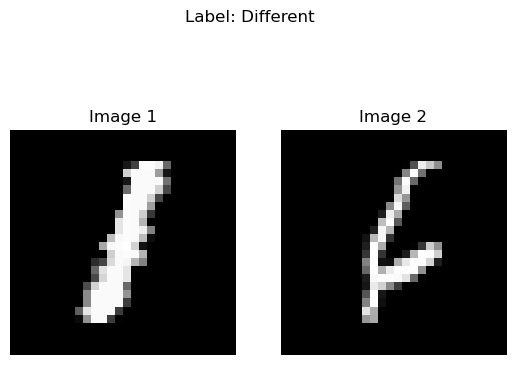

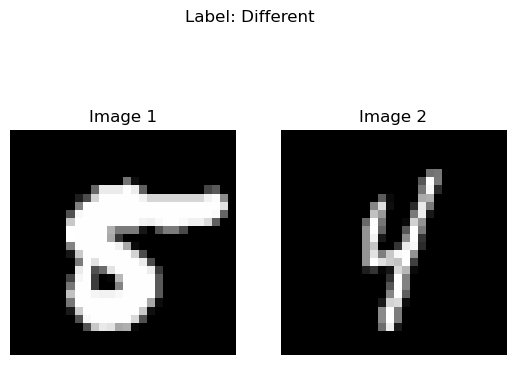

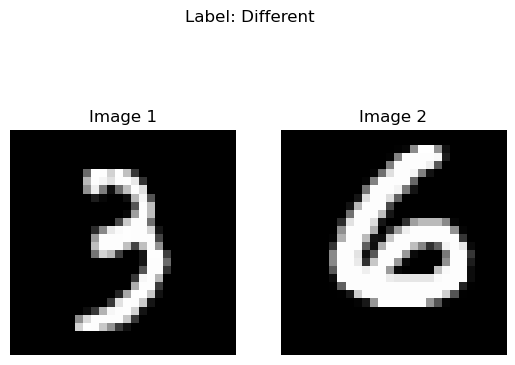

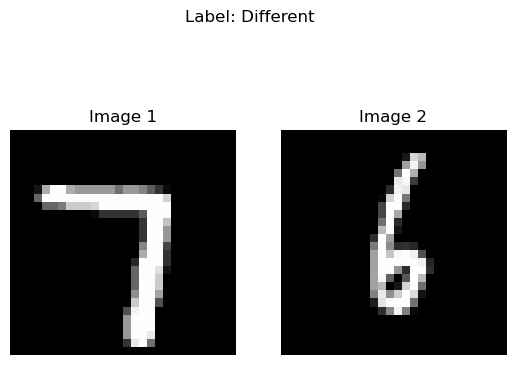

In [60]:
import matplotlib.pyplot as plt

def display_image_pair(index, pairs, pair_labels):
    for index in index:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        
        ax1.imshow(pairs[index][0].reshape(28, 28), cmap='gray')
        ax1.set_title('Image 1')
        ax1.axis('off')
        
        ax2.imshow(pairs[index][1].reshape(28, 28), cmap='gray')
        ax2.set_title('Image 2')
        ax2.axis('off')
        
        plt.suptitle(f"Label: {'Same' if pair_labels[index] == 1 else 'Different'}")
        plt.show()

# Display an image pair (example: index 7)
random_images = np.random.randint(0, len(train_pairs), size=5)
display_image_pair(random_images, train_pairs, train_pair_labels)

In [61]:
shared_vision_model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the shared vision model
shared_vision_model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_pair_labels,
                        batch_size=256,
                        epochs=5,
                        validation_data=([test_pairs[:, 0], test_pairs[:, 1]], test_pair_labels))


Epoch 1/5
79/79 [==============================] - 70s 875ms/step - loss: 0.6953 - accuracy: 0.5034 - val_loss: 0.6952 - val_accuracy: 0.5149
Epoch 2/5
79/79 [==============================] - 63s 804ms/step - loss: 0.6897 - accuracy: 0.5354 - val_loss: 0.6965 - val_accuracy: 0.5014
Epoch 3/5
79/79 [==============================] - 61s 770ms/step - loss: 0.6848 - accuracy: 0.5548 - val_loss: 0.6991 - val_accuracy: 0.5062
Epoch 4/5
79/79 [==============================] - 61s 776ms/step - loss: 0.6790 - accuracy: 0.5694 - val_loss: 0.7025 - val_accuracy: 0.5074
Epoch 5/5
79/79 [==============================] - 61s 769ms/step - loss: 0.6714 - accuracy: 0.5888 - val_loss: 0.7097 - val_accuracy: 0.5032


The model doesn't seem to be learning anything, and is just guessing (results are pretty much 50/50)

Let's try adding another linear layer at the end and see if that helps.

In [63]:
from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten
from keras.models import Model

# First, define the vision modules
digit_input = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3))(digit_input)
x = Conv2D(32, (3, 3))(x)
x = MaxPooling2D((2, 2))(x)
out = Flatten()(x)

vision_model = Model(digit_input, out, name = 'vision_model')

# Then define the tell-digits-apart model
digit_a = Input(shape=(28, 28, 1))
digit_b = Input(shape=(28, 28, 1))

# The vision model will be shared, weights and all
out_a = vision_model(digit_a)
out_b = vision_model(digit_b)

concatenated = keras.layers.concatenate([out_a, out_b])
out = Dense(512, activation='relu')(concatenated)
out = Dense(1, activation='sigmoid')(out)
shared_vision_model = Model([digit_a, digit_b], out, name = 'shared_vision')

In [64]:
shared_vision_model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

shared_vision_model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_pair_labels,
                        batch_size=256,
                        epochs=5,
                        validation_data=([test_pairs[:, 0], test_pairs[:, 1]], test_pair_labels))

Epoch 1/5
79/79 [==============================] - 27s 331ms/step - loss: 0.5309 - accuracy: 0.7186 - val_loss: 0.3532 - val_accuracy: 0.8469
Epoch 2/5
79/79 [==============================] - 25s 318ms/step - loss: 0.2900 - accuracy: 0.8765 - val_loss: 0.2643 - val_accuracy: 0.8924
Epoch 3/5
79/79 [==============================] - 25s 319ms/step - loss: 0.1823 - accuracy: 0.9279 - val_loss: 0.2129 - val_accuracy: 0.9155
Epoch 4/5
79/79 [==============================] - 25s 315ms/step - loss: 0.1103 - accuracy: 0.9588 - val_loss: 0.2134 - val_accuracy: 0.9204
Epoch 5/5
79/79 [==============================] - 25s 314ms/step - loss: 0.0650 - accuracy: 0.9778 - val_loss: 0.2344 - val_accuracy: 0.9204


Great, its learning. Now lets try to optimize it by increasing the amount of paramters, and lowering the batch size for smoother gradients, and another couple of epochs

In [65]:
digit_input = Input(shape=(28, 28, 1))
x = Conv2D(64, (3, 3))(digit_input)
x = Conv2D(64, (3, 3))(x)
x = MaxPooling2D((2, 2))(x)
out = Flatten()(x)

vision_model = Model(digit_input, out, name = 'vision_model')

# Then define the tell-digits-apart model
digit_a = Input(shape=(28, 28, 1))
digit_b = Input(shape=(28, 28, 1))

# The vision model will be shared, weights and all
out_a = vision_model(digit_a)
out_b = vision_model(digit_b)

concatenated = keras.layers.concatenate([out_a, out_b])
out = Dense(1028, activation='relu')(concatenated)
out = Dense(1, activation='sigmoid')(out)
shared_vision_model = Model([digit_a, digit_b], out, name = 'shared_vision')

In [66]:
shared_vision_model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

shared_vision_model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_pair_labels,
                        batch_size=64,
                        epochs=7,
                        validation_data=([test_pairs[:, 0], test_pairs[:, 1]], test_pair_labels))

Epoch 1/7
313/313 [==============================] - 113s 358ms/step - loss: 0.4678 - accuracy: 0.7685 - val_loss: 0.2909 - val_accuracy: 0.8802
Epoch 2/7
313/313 [==============================] - 110s 351ms/step - loss: 0.2329 - accuracy: 0.9051 - val_loss: 0.2197 - val_accuracy: 0.9113
Epoch 3/7
313/313 [==============================] - 110s 353ms/step - loss: 0.1304 - accuracy: 0.9513 - val_loss: 0.2106 - val_accuracy: 0.9217
Epoch 4/7
313/313 [==============================] - 111s 355ms/step - loss: 0.0718 - accuracy: 0.9726 - val_loss: 0.2299 - val_accuracy: 0.9245
Epoch 5/7
313/313 [==============================] - 111s 355ms/step - loss: 0.0445 - accuracy: 0.9851 - val_loss: 0.2378 - val_accuracy: 0.9295
Epoch 6/7
313/313 [==============================] - 112s 358ms/step - loss: 0.0270 - accuracy: 0.9905 - val_loss: 0.3088 - val_accuracy: 0.9301
Epoch 7/7
313/313 [==============================] - 116s 370ms/step - loss: 0.0316 - accuracy: 0.9893 - val_loss: 0.3190 - val_ac

Much better!